In [1]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import scipy.io
from scipy.interpolate import griddata

!pip install pyDOE
from pyDOE import lhs

from collections import OrderedDict
from tqdm import tqdm

sns.set_style("white")

C:\Users\ameyv\anaconda3\envs\amey-pinn\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Multi-layer Perceptron (Deep Neural Network)
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        self.depth = len(layers) - 1
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1])))
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1])))
        layerDict = OrderedDict(layer_list)
        
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out

In [3]:
# Physics Informed Neural Network
class PINN():
    def __init__(self, X_s, s, X_f, layers, lb, ub, nu):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

        # boundary conditions
        self.lb = torch.tensor(lb).float().to(device)
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        self.x_s = torch.tensor(X_s[:, 0:1], requires_grad=True).float().to(device)
        self.y_s = torch.tensor(X_s[:, 1:2], requires_grad=True).float().to(device)
        self.x_f = torch.tensor(X_f[:, 0:1], requires_grad=True).float().to(device)
        self.y_f = torch.tensor(X_f[:, 1:2], requires_grad=True).float().to(device)
        self.s = torch.tensor(s).float().to(device)
        
        # deep neural networks
        self.layers = layers
        self.nu = nu
        self.dnn = DNN(layers).to(device)
        
        # optimizers: using the same settings
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"      
        )
        self.iter = 0

    def net_s(self, x, y):  
        s = self.dnn(torch.cat([x, y], dim=1))
        return s
    
    def net_f(self, x, y):
        s = self.net_s(x, y)
        u = s[:,0]
        v = s[:,1]
        p = s[:,2]

        du_dx = torch.autograd.grad(inputs=x, outputs=u, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        dv_dx = torch.autograd.grad(inputs=x, outputs=v, grad_outputs=torch.ones_like(v), retain_graph=True, create_graph=True)[0]
        dp_dx = torch.autograd.grad(inputs=x, outputs=p, grad_outputs=torch.ones_like(p), retain_graph=True, create_graph=True)[0]
        
        du_dy = torch.autograd.grad(inputs=y, outputs=u, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        dv_dy = torch.autograd.grad(inputs=y, outputs=v, grad_outputs=torch.ones_like(v), retain_graph=True, create_graph=True)[0]
        dp_dy = torch.autograd.grad(inputs=y, outputs=p, grad_outputs=torch.ones_like(p), retain_graph=True, create_graph=True)[0]

        du_dxx = torch.autograd.grad(inputs=x, outputs=du_dx, grad_outputs=torch.ones_like(du_dx), retain_graph=True, create_graph=True)[0]
        du_dyy = torch.autograd.grad(inputs=y, outputs=du_dy, grad_outputs=torch.ones_like(du_dy), retain_graph=True, create_graph=True)[0]
        dv_dxx = torch.autograd.grad(inputs=x, outputs=dv_dx, grad_outputs=torch.ones_like(dv_dx), retain_graph=True, create_graph=True)[0]
        dv_dyy = torch.autograd.grad(inputs=y, outputs=dv_dy, grad_outputs=torch.ones_like(dv_dy), retain_graph=True, create_graph=True)[0]
        
        f1 = u.squeeze() * du_dx + v.squeeze() * du_dy + dp_dx - self.nu * (du_dxx + du_dyy)
        f2 = u.squeeze() * dv_dx + v.squeeze() * dv_dy + dp_dy - self.nu * (dv_dxx + dv_dyy)
        f = f1 + f2
        return f
    
    def loss_func(self):
        self.optimizer.zero_grad()
        
        s_pred = self.net_s(self.x_s, self.y_s)
        f_pred = self.net_f(self.x_f, self.y_f)
#         print("s:", type(self.s))
#         print("f_pred:", type(f_pred))
#         print("s_pred:", type(s_pred))
        loss_s = torch.mean((self.s - s_pred) ** 2)
        loss_f = torch.mean(f_pred ** 2)
        
        loss = loss_s + loss_f
        
        loss.backward()
        self.iter += 1
        if self.iter % 100 == 0:
            print('Iter %d, Loss: %.5e, Loss_u: %.5e, Loss_f: %.5e' % (self.iter, loss.item(), loss_s.item(), loss_f.item()))
        return loss
    
    def train(self):
        self.dnn.train()
        self.optimizer.step(self.loss_func)
     
    def predict(self, X):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        y = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval()
        s = self.net_s(x, y)
        f = self.net_f(x, y)
        s = s.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return s, f

In [4]:
N_u = 200
N_f = 400

Re = 20
nu = 1 / Re
lamb = 1 / (2 * nu) - np.sqrt(1 / (4 * nu ** 2) + 4 * np.pi ** 2)

layers = [2, 50, 50, 50, 50, 3]

h = 0.05
k = 0.05
x = torch.arange(0, 1, h)
y = torch.arange(0, 1, k)

print("x:", x.shape)
print("y:", y.shape)

X, Y = np.meshgrid(x,y)
X = torch.from_numpy(X)
Y = torch.from_numpy(Y)

print("X:", X.shape)
print("Y:", Y.shape)

Exact = torch.zeros(X.shape[0],X.shape[1],3)
Exact_U = 1-(torch.exp(lamb*X))*(torch.cos(2*math.pi*Y))
Exact_V = (lamb/(2*math.pi))*(torch.exp(lamb*X))*(torch.sin(2*math.pi*Y))
Exact_P = (1/2)*(1-(torch.exp(2*lamb*X)))
Exact[:,:,0] = Exact_U
Exact[:,:,1] = Exact_V
Exact[:,:,2] = Exact_P

print("Exact:",Exact.shape)

X_test = np.hstack((X.flatten()[:,None], Y.flatten()[:,None]))
s_test = torch.reshape(Exact, (-1, 3))             

print("X_test:", X_test.shape)
print("s_test:", s_test.shape)

# Domain bounds
lb = X_test.min(0)
ub = X_test.max(0) 


idx = np.random.choice(400, N_u, replace=False)
X_s_train = X_test[idx, :]
s_train   = s_test[idx, :]

print("X_s_train:", X_s_train.shape)
print("s_train:", s_train.shape)

X_f_train = lb + (ub-lb)*lhs(2, N_f)
X_f_train = np.vstack((X_f_train, X_s_train))

print("X_f_train:", X_f_train.shape)

x: torch.Size([20])
y: torch.Size([20])
X: torch.Size([20, 20])
Y: torch.Size([20, 20])
Exact: torch.Size([20, 20, 3])
X_test: (400, 2)
s_test: torch.Size([400, 3])
X_s_train: (200, 2)
s_train: torch.Size([200, 3])
X_f_train: (600, 2)


In [5]:
model = PINN(X_s_train, s_train, X_f_train, layers, lb, ub, nu)
model.train()

C:\Users\ameyv\AppData\Local\Temp\ipykernel_24940\1660453502.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.s = torch.tensor(s).float().to(device)


Iter 100, Loss: 2.09901e-02, Loss_u: 1.74318e-02, Loss_f: 3.55826e-03
Iter 200, Loss: 1.79360e-02, Loss_u: 1.47897e-02, Loss_f: 3.14623e-03
Iter 300, Loss: 1.71650e-02, Loss_u: 1.36070e-02, Loss_f: 3.55803e-03
Iter 400, Loss: 1.68705e-02, Loss_u: 1.32064e-02, Loss_f: 3.66415e-03
Iter 500, Loss: 1.66852e-02, Loss_u: 1.31737e-02, Loss_f: 3.51147e-03
Iter 600, Loss: 1.65215e-02, Loss_u: 1.30616e-02, Loss_f: 3.45988e-03
Iter 700, Loss: 1.63493e-02, Loss_u: 1.27520e-02, Loss_f: 3.59733e-03
Iter 800, Loss: 1.62505e-02, Loss_u: 1.27642e-02, Loss_f: 3.48629e-03
Iter 900, Loss: 1.62000e-02, Loss_u: 1.26819e-02, Loss_f: 3.51811e-03
Iter 1000, Loss: 1.61747e-02, Loss_u: 1.26723e-02, Loss_f: 3.50249e-03
Iter 1100, Loss: 1.61543e-02, Loss_u: 1.26699e-02, Loss_f: 3.48446e-03
Iter 1200, Loss: 1.61244e-02, Loss_u: 1.25932e-02, Loss_f: 3.53126e-03
Iter 1300, Loss: 1.60910e-02, Loss_u: 1.25681e-02, Loss_f: 3.52287e-03
Iter 1400, Loss: 1.60580e-02, Loss_u: 1.25351e-02, Loss_f: 3.52287e-03
Iter 1500, Loss

Iter 11700, Loss: 1.52108e-02, Loss_u: 1.16676e-02, Loss_f: 3.54320e-03
Iter 11800, Loss: 1.51998e-02, Loss_u: 1.16371e-02, Loss_f: 3.56270e-03
Iter 11900, Loss: 1.51845e-02, Loss_u: 1.16138e-02, Loss_f: 3.57063e-03
Iter 12000, Loss: 1.51625e-02, Loss_u: 1.15529e-02, Loss_f: 3.60960e-03
Iter 12100, Loss: 1.51359e-02, Loss_u: 1.14998e-02, Loss_f: 3.63615e-03
Iter 12200, Loss: 1.50909e-02, Loss_u: 1.14905e-02, Loss_f: 3.60040e-03
Iter 12300, Loss: 1.50117e-02, Loss_u: 1.13146e-02, Loss_f: 3.69714e-03
Iter 12400, Loss: 1.49252e-02, Loss_u: 1.12093e-02, Loss_f: 3.71591e-03
Iter 12500, Loss: 1.48145e-02, Loss_u: 1.10498e-02, Loss_f: 3.76472e-03
Iter 12600, Loss: 1.47004e-02, Loss_u: 1.09042e-02, Loss_f: 3.79614e-03
Iter 12700, Loss: 1.45858e-02, Loss_u: 1.08352e-02, Loss_f: 3.75055e-03
Iter 12800, Loss: 1.45003e-02, Loss_u: 1.08563e-02, Loss_f: 3.64401e-03
Iter 12900, Loss: 1.44159e-02, Loss_u: 1.07970e-02, Loss_f: 3.61892e-03
Iter 13000, Loss: 1.43569e-02, Loss_u: 1.07855e-02, Loss_f: 3.57

In [6]:
s_pred, f_pred = model.predict(X_test)

# Relative L2 Error
error_s = np.linalg.norm(s_test-s_pred,2)/np.linalg.norm(s_test,2)
print('Relative L2 Error y: %e' % (error_s))

# Absolute error
u_pred = griddata(X_test, s_pred[:,0].flatten(), (X, Y), method='cubic')
v_pred = griddata(X_test, s_pred[:,1].flatten(), (X, Y), method='cubic')
p_pred = griddata(X_test, s_pred[:,2].flatten(), (X, Y), method='cubic')

Error = np.abs(Exact[:,:,0] - u_pred) + np.abs(Exact[:,:,1] - v_pred) + np.abs(Exact[:,:,2] - p_pred)

Relative L2 Error y: 1.141800e-01


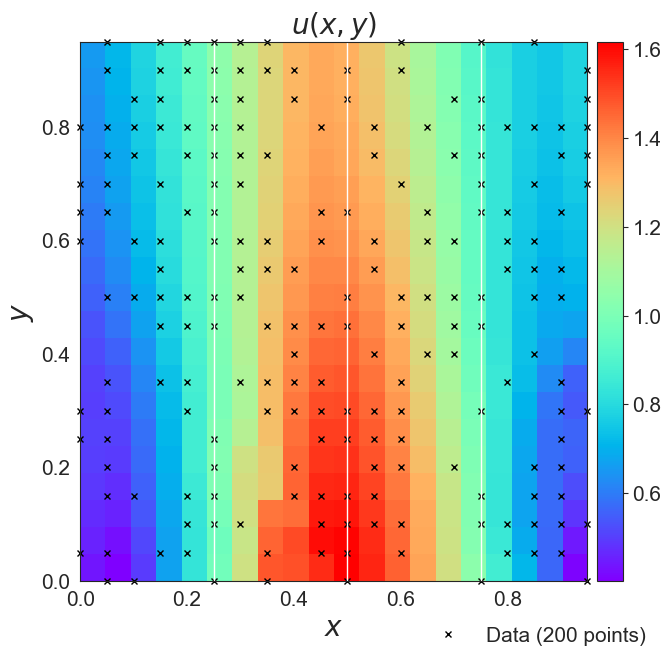

In [8]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)

h = ax.imshow(u_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[y.min(), y.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

ax.plot(
    X_s_train[:,1], 
    X_s_train[:,0], 
    'kx', label = 'Data (%d points)' % (s_train[:,0].shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(y[5]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(y[10]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(y[15]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$x$', size=20)
ax.set_ylabel('$y$', size=20)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
ax.set_title('$u(x,y)$', fontsize = 20) # font size doubled
ax.tick_params(labelsize=15)

plt.show()

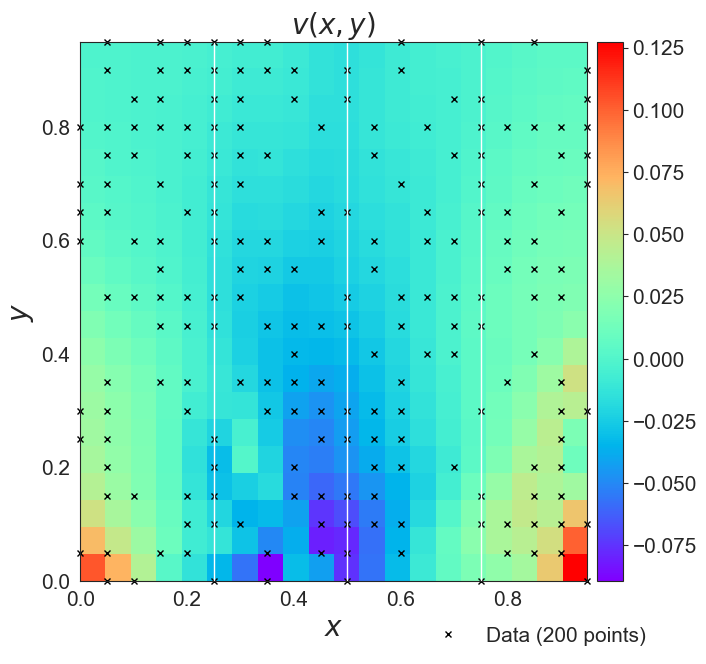

In [9]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)

h = ax.imshow(v_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[y.min(), y.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

ax.plot(
    X_s_train[:,1], 
    X_s_train[:,0], 
    'kx', label = 'Data (%d points)' % (s_train[:,0].shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(y[5]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(y[10]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(y[15]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$x$', size=20)
ax.set_ylabel('$y$', size=20)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
ax.set_title('$v(x,y)$', fontsize = 20) # font size doubled
ax.tick_params(labelsize=15)

plt.show()

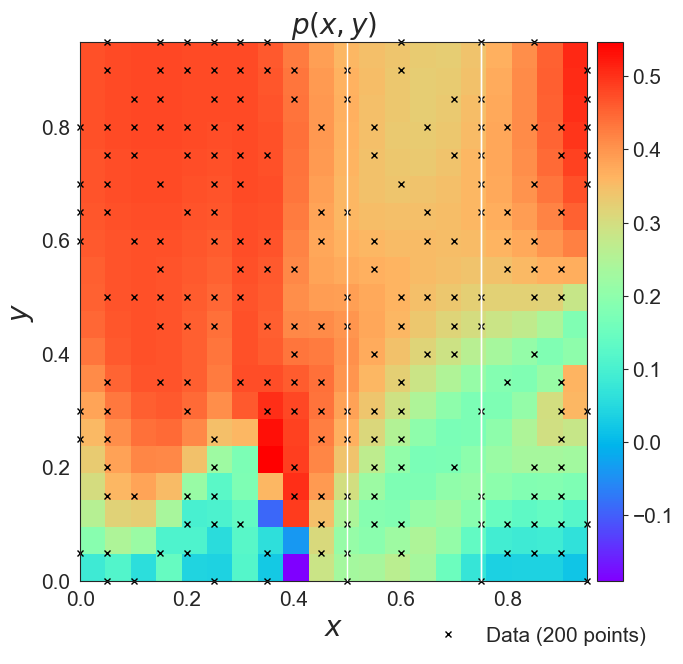

In [10]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)

h = ax.imshow(p_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[y.min(), y.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

ax.plot(
    X_s_train[:,1], 
    X_s_train[:,0], 
    'kx', label = 'Data (%d points)' % (s_train[:,0].shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(y[15]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(y[10]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(y[15]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$x$', size=20)
ax.set_ylabel('$y$', size=20)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
ax.set_title('$p(x,y)$', fontsize = 20) # font size doubled
ax.tick_params(labelsize=15)

plt.show()